# Empalme con la clase anterior

Definamos conceptos importantes:
* **prior distribution** $p(z)$ (distrubucion a priori)
Esta la probabilidad del espacio latente.
* **posterior distribution** $$p(z | x)$$

Vamos a ver que para resolver el problema de VAE necesitamos, como para casi todo en ML, una funcion de costo.  Esta funcion de costo tiene dos partes (esto lo veremos)

1. Una parte para la reconstruccion, que garantice que la salida esta tan cerca como se quiere a lo deseado.

2. Encontramos la Kullback-Leibler divergence (KL). El articulo original en las notas de clase. Esta parte de la funcion de costo se encarga de que la distribucion a posteriori sea tan cerca como se pueda a una $\mathcal{N}(0, I_d)$. Donde
$I_d$ es la identidad en el espacio de $d$ dimensiones y $d$ es el numero de dimensiones del espacio latente $z$.

Nuesto espacio de salida es $X=\{x_1, x_2, \cdots, x_m \}$
La idea es maximizar el "likelihood" (verosimilitud) que es
la probabilidad de $X$. Para esto pensemos en la probabilidad marginal

$$p_{\theta}(x) = \int p_{\theta}(x , z) dz . $$
Esta expresion no es facil de calcular. Es **intractable**
Por que es dificil calcular esto:
1. El espacio latente puede tener muchas dimensiones. La integral se vuelve inmanejable.
2. El integrando no es anlitico.
Un asunto de notacion: Vamos a escrbir $p(x)$ en vez de
$p_\theta(x)$, para evitar escribir mucho. La palabra "variational" tiene que ver con que se escoge otra distribucion
(variational) que es $q_\phi(z | x)$. Esta es la que al final nos a ayudar a resolver el problema. Donde $\phi$ es el parametro de el decoder. Veamos como resolvemos esto.
Usamos logaritmo.


$$ \log p_{\theta}(x) = \log \int p_\theta(x,z) dz  =
\log \int \frac{p_\theta(x,z)}{q_\phi(z | x)} q_\phi(z | x) dz
\tag{1} $$



Vamos a buscar una cota inferior de esta expresion la cual queremos "empujar" hacia arriba (maximizar). Para hallar esta cota inferior usamos la desigualdad de Jensen.

Si $f$ es convexa ( logaritmo es convexo)
$$ f ( \mathbb{E}[X])  \le \mathbb{E} [ f(x)]$$
En nuestro caso la funcion $f$ es el logaritmo.
El lado derecho de la ecuacion (1) es

$$\log \mathbb{E}_{q_\phi(z | x)} \left [  \frac{p_\theta(x,z)}{q_\phi(x,z)} \right ] \tag{2} $$.
El logaritmo es concavo pero si cambiamos el signo es convexo.
La desigualdad de Jensen para este caso se traduce en
$$-\log E_{q_\phi(z|x)} \left [ \frac{p_\theta(x,z)}{q_\phi(z | x)}  \right ] \le - \mathrm{E}_{q_\phi(z | x)}
\log \left [  \frac{p_\theta(x,z)}{q_\theta(z | x) }\right ] $$

Podemos escribir esto , multiplicando por -1

$$\log E_{q_\phi(z|x)} \left [ \frac{p_\theta(x,z)}{q_\phi(z | x)}  \right ] \ge  \mathrm{E}_{q_\phi(z | x)}  \tag{3} $$
DE las ecuaciones (1) , (2) y (3)

$$\log p_\theta(x) \ge  \mathbb{E}_{q_\phi(z | x)}
\left [  \log \frac{p_\theta(x,z)}{q_\phi(z | x)} \right ] $$

Esta desigualda es famosa y se llama
**ELBO**: Evidence Lower Bound
[Wikipedia muestra](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Lo que debemos hacer es maximar el "likelihood" "empujando" esa cota inferior (Bounda) hacia arriba lo que mas podamos.

La funcion de costo consiste en maximar esta cota (inferior)

$$C(\theta, \phi, x) = \mathbb{E}_{q_\phi(z | x)}
\left [  \log \frac{q_{\theta}(z | x)}{p_\theta(x,z)}  \right ]. $$

Vamos a hacer un desarrollo sobre esta funcion de costo
usando (la regla de la cadena para probabilidades, se saca
del teorema de Bayes).
$$p_\theta(x,z) = p_\theta(x | z) p(z)  $$

\begin{eqnarray}
C(\theta, \phi, x) &=&
\mathbb{E}_{q_\phi(z | x)} [ \log q_\phi(z | x)] -
\mathbb{E}_{q_\phi(z | x)}[ \log p_\theta(x | z)] -
\mathbb{E}_{q_\phi(z | x)} [ \log p(z) ] \\
&=& - \mathbb{E}_{q_\phi(z | x)}[ \log p_\theta(x | z)]
+ \mathbb{E}_{q_\phi(z | x)} \log \frac{q_\phi(z | x)}{p(z)}  \\
&=&\underbrace{-\mathbb{E}_{q_{\phi}(z | x)}
[ \log p_\theta(x | z)]}_{\text{reconstruction}}
+ \underbrace{D_{KL} \left (q_\phi(z | x) \parallel p(z) \right )}_{KL Divergence}
\end{eqnarray}

Expliqemos los terminos de esta ecuacion de costo y donde van en la red.

* **Input stage of encoder** $q_\phi(z | x)$: Esta reprenta la distribucion posterior que es aproximada esta definida sobre la variable latente $z$, dado una entrada $x$ (aca $x$ es entrada no salida). Esta distribucion se crea en la red inmediatamente luego del "encoding". El encoder recibe los datos $x$ y saca los parametros $\sigma, \mu$. Esta distribucion es la que genera
$q_\phi(z | x)$.  Inmediatamente luego del cuello de botella.

* **muestreo del espacio latente**: $z \sim q_\phi(z | x)$:
Se genera una representacion de $x$ (sampling trick)
a partir de $z$. Este muestreo es tipicamente una distribucion normal $\mathcal{N}(0, I)$.

* **Decoder y reconstruccion** $p_\theta(x | z)$. Este la verosimilitud de los datos de salida $x$ dada la entrada $z$.
El "decoder" usa la reconsrruccion para aproximar $x$.

* **LK Divergence term**: $D_{LK} ( q_\phi(z | x) \parallel p(z))$ Este termino mide la "distancia" entre dos distribuciones normales. La $p(z)$ es $\mathcal{N}(0, I)$.

* **Reconstruction loss**: $-\mathbb{E}_{q_\phi(z | x)} [ \log p_\theta(x | z)] $. El objeto  que la verosimilitud
$p_\theta(x | z)$ reconstruya $x$, sea tan cercana a 1 como sea posible.








En general la funcion de costo es

$$J(\theta, \phi) = \frac1m \sum_{i=1}^m C(\theta, \phi, x_i) $$

Se puede probar (tarea )

$$D_{KL}( q_\phi(z | x) \parallel p(z) ) = \frac12 \sum_{j=1}^d (1 - \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 $$

Vamos a encontra la relacion de $D_{KL}$ con la entropia.

Cual es la cantidad de informacion en un objeto?
Digamos un objeto tiene solo dos estados $1,0$ (bit)
La cantidad de informacion es 1

$$I = n = \log_2 N $$
$N$ es el numero de estados.
En el discreto $N= 2^n$. Pero en estadistica se prefiere el uso de las probabilidades. Entonces se considera

$$p(x) = \frac{1}{N} = \frac{1}{2^n} $$

Para extraer la informacion del conenido se escribe

$$I(x) = - \log p(x) = -\log_{2} \frac{1}{N} = -\log_2 \frac{1}{2^n} = - (-n) = n$$

La **entropia** es

$$H(X)=\mathbb{E}(I(x))= -\sum_{i=1}^n p(x_i) \log p(x_i)$$
Si es continuo

$$H(x) = \mathbb{E}(I(x)) = -\int p(x) \log p(x) dx $$

Recuerden la definicion de $D_{KL}$

$$D_{KL}(P \parallel Q) = \int p(x)[ \log p(x) - \log (q(x))] dx = \int p(x) \log \frac{p(x)}{q(x)} dx$$
Esto realmente no es una metrica en el sentido matematico formal por que

$$D_{KL}(P \parallel Q) \ne D_{KL}(Q \parallel P) $$


* **Reparameterization trick**
Como se muestrea en el espacio latente?

$$z = \mu + \sigma \circ \epsilon $$
$\epsilon$ es una constante y con media $\mathcal{N}(0, 1)$.
Con eso $p(z)$ tiene es normal con media $\mu$ y desviacion
estandar $\sigma$.

Como queda el flujo (arquitectura) con esto ?






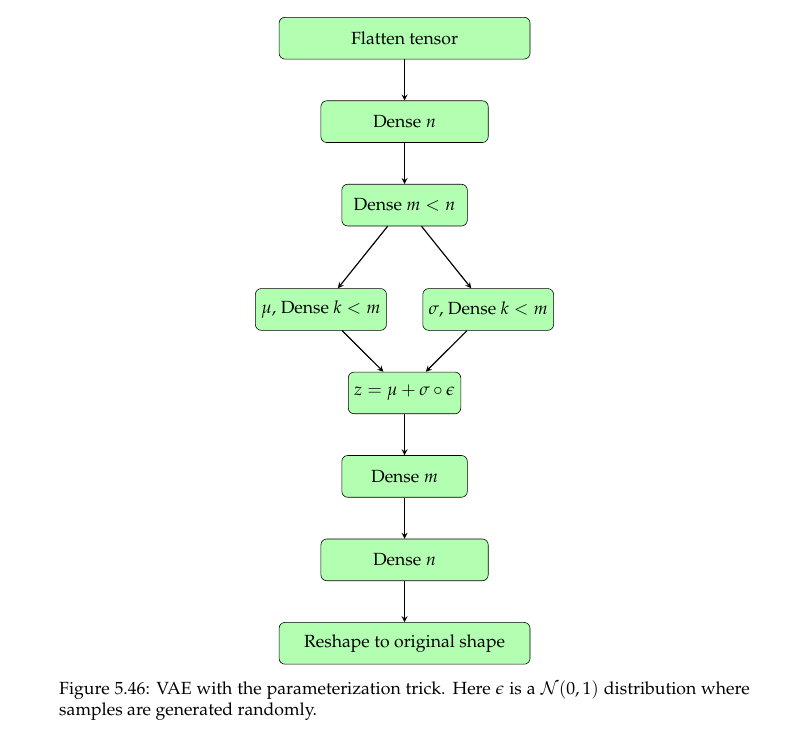

# Disentagled Variation Auto-encoders (VA desenmarañados)
La idea aca es introducir un nuevo parametro $\beta$ de tal forma
que actue como regularizador. Ya explico.

Esta idea fue introducida por Higgins, et. al., 2017.

La funcion de costo es

$$J(\theta, \phi, \beta) = -\mathbb{E}_{q_\phi(z | x)}
[ \log p_\theta(x | z) ] + \beta D_{KL}( q_\varphi(z | x) \parallel p(z)) $$

donde el $\beta$ sirve como regularizador en la $D_{KL}$.
Si $\beta=1$ es el clasico VAE, si $\beta \ll 1$ entonces
estamos ignorando el termino $D_{KL}$ y si $\beta \gg 1$,
estamos exagerando la influencia del $D_{KL}$ en la inversion.



La recomendacion es que miren los codigos en las notas de clase.

# GANs: Generative Adversarial Networks:
Redes adversarial generativas.
Este trabajo fue desarrollado por Ian J. Goodfellow et. al. 2014.
(referencia en las notas de clase).
El concepto es bien interesante.

La idea es de dos redes
Para explicar voy a formular el model del detective y el
falsificador.
* La $D$ discriminator: Por ejemplo el detective.
El trabajo del detective es juzgar la muestra que le entra
y decir si es "fake" o no. Es falso o no. Estamos viendo
una salida binaria. F o V ($y=1$ o $y=0$).
* La $G$ generator. Este es el falsificador. Que comienza a hacer un mal trabajo, pero con ayuda de la calificacion del detective lo va perfeccionando.

Vamos a mostrar un par de figuras para explicar mejor el proceso.

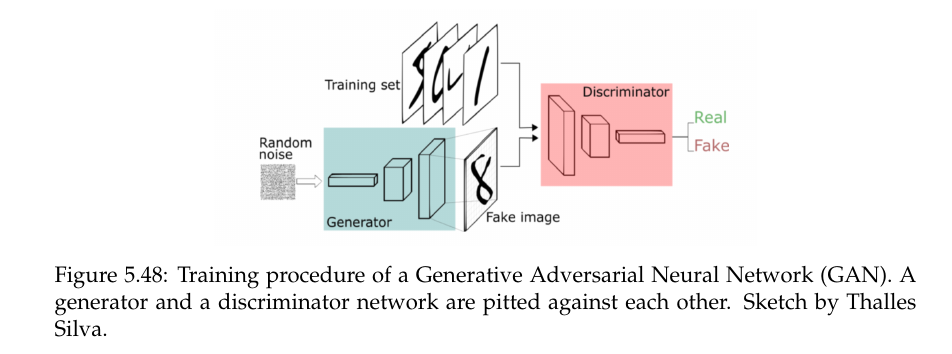

i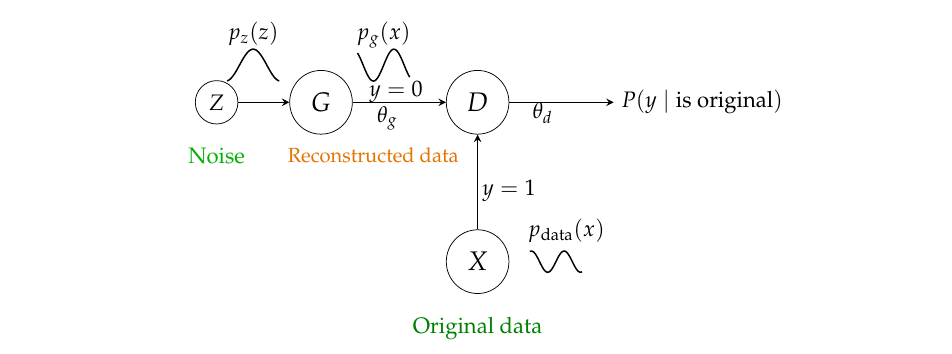